# Test Trained Signal Classification and Reconstruction Networks (SCRNet)
Model performance of the Signal Classification and Reconstruction Network (SCRNet) to reconstruct and classify compressed Extended-MNIST <span style="color:blue">***(EMNIST)*** letter</span> images with imposed Poisson noise.

* First Run: **scrnet_train_models_emnist_tf.ipynb** to train the models for each compression type

**Author:** Fabian Santiago  
**Update:** September 24, 2024

Jupyer Notebook Version: 6.5.4  
Python Version: 3.11.5  
TensorFlow Version: 2.16.2

***[Download EMNIST](https://pypi.org/project/emnist/)***


## Import Modules and Libraries

In [1]:
# Import necessary modules and libraries 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import h5py
import string
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from emnist import extract_training_samples, extract_test_samples

2024-09-25 15:11:38.406051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Training Data
Load traning data or load EMNIST data and create training data if it has not already been created

In [2]:
# Output dimensions
out_dim = 28

# Characters
alp_char = list(string.ascii_uppercase)

# Directory name
directory = 'training_data'
    
# Load EMNIST: Used for 4x4, 7x7, 14x14, and 28x28 input architectures
clean_train, train_labels = extract_training_samples('letters')    
clean_test, test_labels   = extract_test_samples('letters')

# Create a dictionary for all 
in_signals_by_cmp = dict.fromkeys(['4x4','7x7','14x14','28x28'],[])

for cmp_dim in [4,7,14,28]:
    # Set EMNIST dataset name
    dat_file = f'{directory}/emnist_{cmp_dim}x{cmp_dim}_train.h5'

    # Load compressed/noisy training data
    with h5py.File(dat_file, 'r') as dat_file:
        # Load compressed noisy training/test images
        noisy_train = dat_file['noisy_train'][:]
        noisy_test  = dat_file['noisy_test'][:]
    
    # Create Dictionary for compressed/noisy signals
    in_signals = dict(zip(['train','test'],[noisy_train,noisy_test]))
    
    # Add to dictionary
    in_signals_by_cmp[f'{cmp_dim}x{cmp_dim}'] = in_signals
    
# Prepare original mnist data for model training
clean_train  = np.array([matrix.reshape(out_dim**2,) for matrix in clean_train/255])
clean_test   = np.array([matrix.reshape(out_dim**2,) for matrix in clean_test/255])
train_labels = train_labels-1
test_labels  = test_labels-1
train_labels = to_categorical(train_labels, num_classes=26)
test_labels  = to_categorical(test_labels, num_classes=26)

## Apply SCRNet to Compressed/Noisy EMNIST Training and Test Sets

## Load Trained Models
Load training models and use them to reconstruct and classify both test and training image signals

In [3]:
# Save the trained model
scrnet4x4    = tf.keras.models.load_model('trained_models/scrnet4x4.keras')
scrnet7x7    = tf.keras.models.load_model('trained_models/scrnet7x7.keras')
scrnet14x14  = tf.keras.models.load_model('trained_models/scrnet14x14.keras')
scrnet28x28  = tf.keras.models.load_model('trained_models/scrnet28x28.keras')

In [4]:
# Create dictionary of trained models
scrnet_models = dict(zip(['4x4','7x7','14x14','28x28'],[scrnet4x4,scrnet7x7,scrnet14x14,scrnet28x28]))

### Apply SCRNet to Training Set

In [5]:
# Apply SCRNet to all training data inputs
pred_train_4x4    = scrnet_models['4x4'].predict(in_signals_by_cmp['4x4']['train'])
pred_train_7x7    = scrnet_models['7x7'].predict(in_signals_by_cmp['7x7']['train'])
pred_train_14x14  = scrnet_models['14x14'].predict(in_signals_by_cmp['14x14']['train'])
pred_train_28x28  = scrnet_models['28x28'].predict(in_signals_by_cmp['28x28']['train'])

3900/3900 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step


### Apply SCRNet to Test Sets

In [6]:
# Apply SCRNet to all testing data inputs (unseen data)
pred_test_4x4    = scrnet_models['4x4'].predict(in_signals_by_cmp['4x4']['test'])
pred_test_7x7    = scrnet_models['7x7'].predict(in_signals_by_cmp['7x7']['test'])
pred_test_14x14  = scrnet_models['14x14'].predict(in_signals_by_cmp['14x14']['test'])
pred_test_28x28  = scrnet_models['28x28'].predict(in_signals_by_cmp['28x28']['test'])

650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


### Save SCRNet Output

In [7]:
# Create dictionary of model output using training set
scrnet_output = dict.fromkeys(['train','test'],[])
scrnet_output['train'] = dict(zip(['4x4','7x7','14x14','28x28'],[pred_train_4x4,pred_train_7x7,pred_train_14x14,pred_train_28x28]))
scrnet_output['test']  = dict(zip(['4x4','7x7','14x14','28x28'],[pred_test_4x4,pred_test_7x7,pred_test_14x14,pred_test_28x28]))

### Plot Example Image Reconstructions and Character Classifications
First we find the indices for each character class and plot examples from each class

In [8]:
# Indices lists of each alpha character
idc_train_list = [[]]*26
idc_test_list  = [[]]*26

# Find indices of each alpha character
for idx in range(26):
    idc_train_list[idx] = np.where(train_labels.argmax(axis=1)==idx)[0]
    idc_test_list[idx]  = np.where(test_labels.argmax(axis=1)==idx)[0]

# One dictionary of indices for alpha charcters by classification
idc_dict = dict(zip(['train','test'],[idc_train_list,idc_test_list]))

In [9]:
# Save output
imdir = 'figures'

# If the save directory does not exist, create it
if not os.path.exists(imdir):
    os.makedirs(imdir)

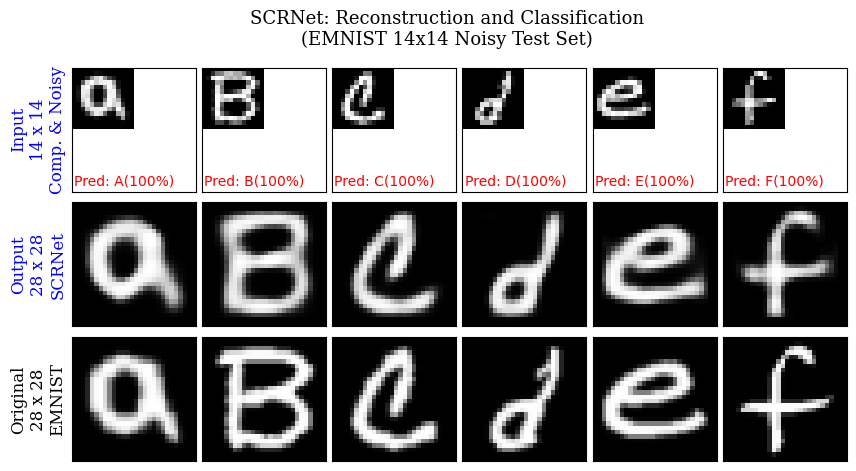

In [10]:
# Create a 3 by 4 subplot handlea
model = '14x14'
datas = 'test'

rnum = 3
cnum = 6
fig, axes = plt.subplots(rnum, cnum, figsize=(10, 5.25))
axes      = axes.flatten()

# Add title
fig.suptitle(f'SCRNet: Reconstruction and Classification\n(EMNIST {model} Noisy T{datas[1:]} Set)',fontsize=13,fontweight='normal', fontfamily='serif')

# Take the nth_img for each character
nth_img = 0
alp_idx = [alph[nth_img-1] for alph in idc_dict[datas]]


cmp_dim = int((len(in_signals_by_cmp[model][datas][0]))**(1/2))

# Plot noisy and decompressed realizations in each subplot
for idx in range(rnum*cnum):
    delidx = idx//cnum

    if idx//cnum == 0:
        # Plot noisy
        axes[idx].imshow(in_signals_by_cmp[model][datas][alp_idx[idx%cnum]].reshape(cmp_dim,cmp_dim),cmap='gray')
        axes[idx].set_xlim(np.array([-0.5, 27.5])) # Set xlim
        axes[idx].set_ylim(np.array([27.5,-0.5])) # Set ylim
        # Add max classification with associated probability
        IDX = scrnet_output[datas][model][1][alp_idx[idx%cnum]].argmax()
        VAL = max(scrnet_output[datas][model][1][alp_idx[idx%cnum]])
        axes[idx].text(0,26,f'Pred: {alp_char[IDX]}({VAL*100:.0f}%)',color='red') # Set title

    if idx//cnum == 1:
        # Plot decompressed with SCRNet
        axes[idx].imshow(scrnet_output[datas][model][0][alp_idx[idx%cnum]].reshape(out_dim,out_dim),cmap='gray')
    
    if idx//cnum == 2:
        if datas == 'test': 
            axes[idx].imshow(clean_test[alp_idx[idx%cnum]].reshape(out_dim,out_dim),cmap='gray')
        else:
            axes[idx].imshow(clean_train[alp_idx[idx%cnum]].reshape(out_dim,out_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'Input\n{cmp_dim} x {cmp_dim}\nComp. & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[cnum].set_ylabel(f'Output\n{out_dim} x {out_dim}\nSCRNet',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[2*cnum].set_ylabel(f'Original\n{out_dim} x {out_dim}\nEMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.0)

# Save file name
imfile = 'recon'

# Save results 
plt.savefig(f'{imdir}/SCRNet{model}_{imfile}_{datas}.png')

# Show the plot
plt.show()

## Confusion Matrix for Character Classification by Model

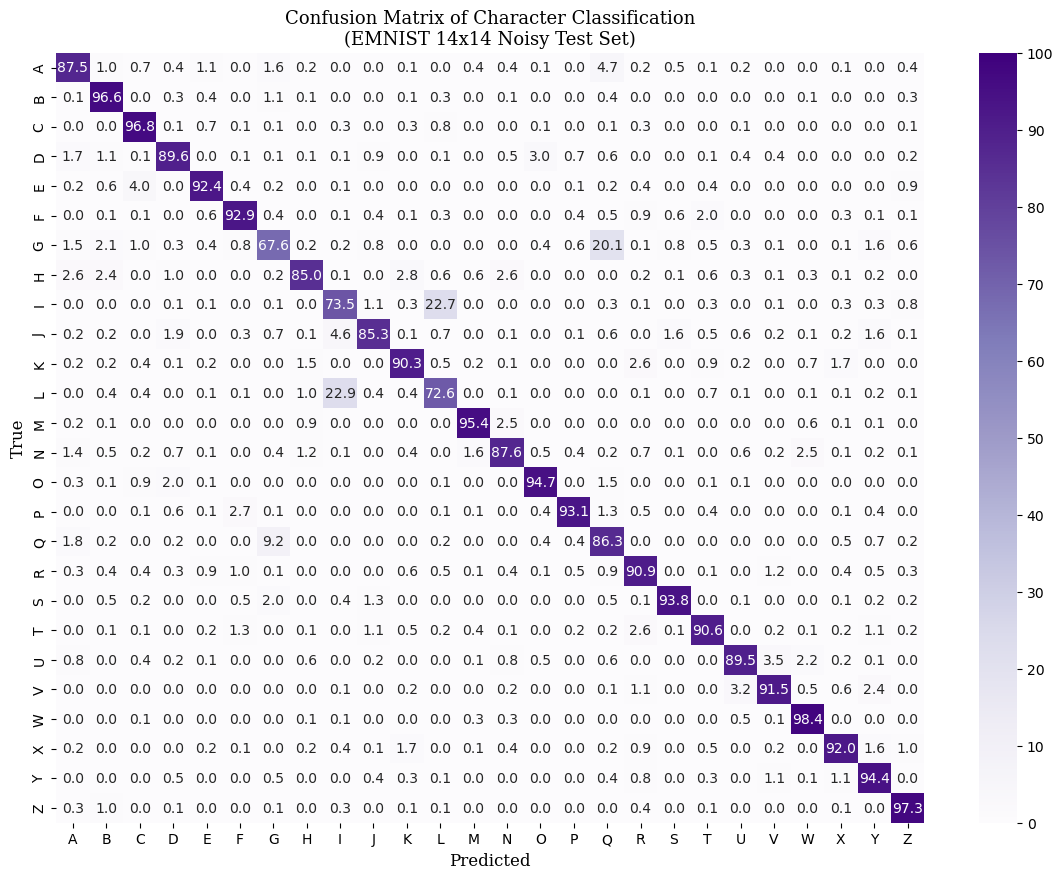

In [11]:
# Set dataset and model
datas = 'test'
model = '14x14'

# Compute confusion matrix
confmat  = confusion_matrix(scrnet_output[datas][model][1].argmax(axis=1),test_labels.argmax(axis=1))
confmat_normed = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]*100

# Plot confusion matrix
plt.figure(figsize=(14, 10))
sns.heatmap(confmat_normed, annot=True, cmap='Purples', fmt=".1f", cbar=True,
            xticklabels=alp_char, yticklabels=alp_char, vmin=0, vmax=100, 
            cbar_kws={'ticks': np.arange(0, 121, 10)})

# Add labels to plot
plt.xlabel('Predicted',fontsize=12, fontfamily='serif')
plt.ylabel('True',fontsize=12, fontfamily='serif')
plt.title(f'Confusion Matrix of Character Classification\n(EMNIST {model} Noisy T{datas[1:]} Set)',fontsize=13,fontweight='normal', fontfamily='serif')

# Save file name
imfile = 'confmat'

# Save results 
plt.savefig(f'{imdir}/SCRNet{model}_{imfile}_{datas}.png')

# Show the plot
plt.show()

## Summary: Precision and Recall for Each Model

In [12]:
# Dictionary for results
report_results = {
    'train': {
        '4x4': {'precision': [], 'recall': []},
        '7x7': {'precision': [], 'recall': []},
        '14x14': {'precision': [], 'recall': []},
        '28x28': {'precision': [], 'recall': []},
    },
    'test': {
        '4x4': {'precision': [], 'recall': []},
        '7x7': {'precision': [], 'recall': []},
        '14x14': {'precision': [], 'recall': []},
        '28x28': {'precision': [], 'recall': []},
    }
}

# Dictionary of training and test data labels 
data_labels = {'train':train_labels.argmax(axis=1),'test':test_labels.argmax(axis=1)}

# Compute precission and recall for each model
for datas_ in ['train','test']:
    for model_ in ['4x4','7x7','14x14','28x28']:
        report = classification_report(data_labels[datas_], 
        scrnet_output[datas_][model_][1].argmax(axis=1), target_names=alp_char, output_dict=True)
        test_nxn = [[0] * 26 for _ in range(2)]  
        for idx, alp in enumerate(alp_char):
            test_nxn[0][idx] = report[alp]['precision']
            test_nxn[1][idx] = report[alp]['recall']
        report_results[datas_][model_]['precision'] = tuple(test_nxn[0])
        report_results[datas_][model_]['recall'] = tuple(test_nxn[1])

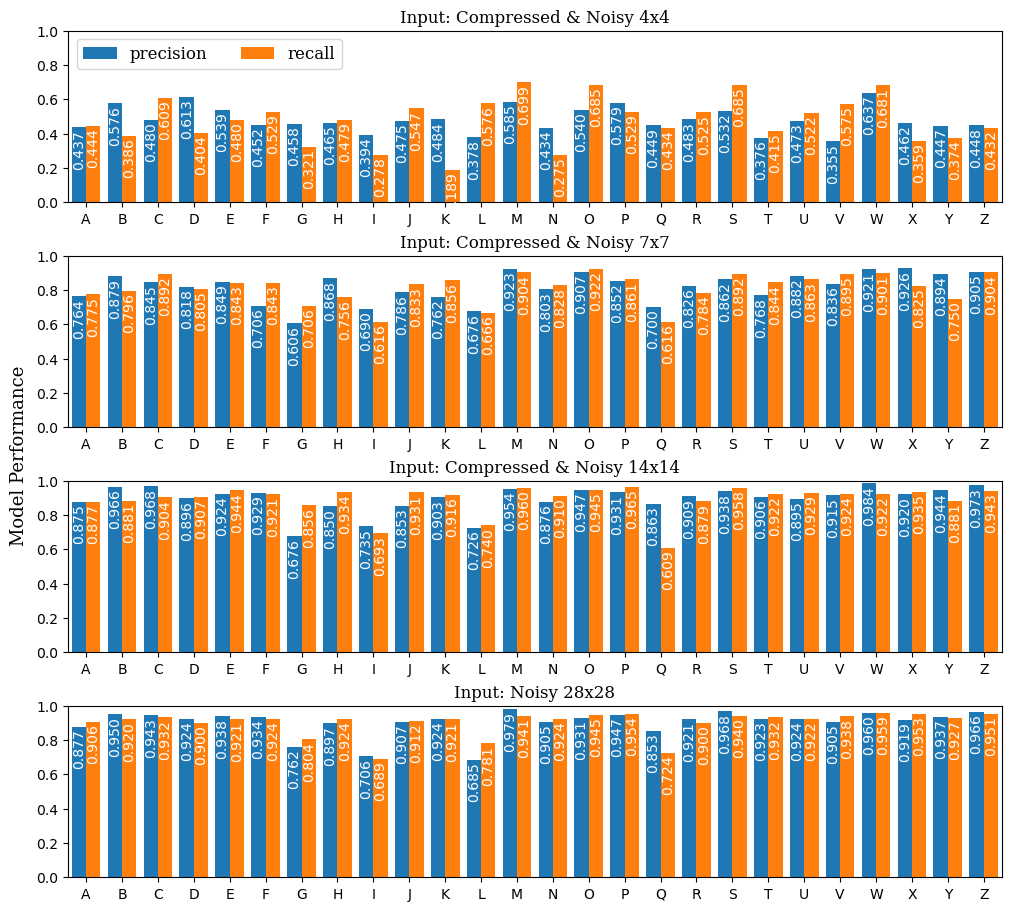

In [13]:
# Set dataset and model
datas  = 'test'

# Create figure handles
fig, axes = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)
axes      = axes.flatten()

# fig.supxlabel(f'Character',fontsize=12,fontweight='normal', fontfamily='serif')
fig.supylabel(f'Model Performance', fontsize=13, fontweight='normal', fontfamily='serif')

# Characters to be plotted
characters = tuple(alp_char)

# Set senter of barplot locations
xlocs = np.arange(len(characters))  # the label locations
    
for idx, model_ in enumerate(['4x4','7x7','14x14','28x28']):
    # Extract particular report
    report_ = report_results[datas][model_]

    width = 0.4  # the width of the bars
    multiplier = -1
    # Add sub title
    if model_ != '28x28':
        axes[idx].set_title(f'Input: Compressed & Noisy {model_}', fontfamily='serif')
    else:
        axes[idx].set_title(f'Input: Noisy {model_}', fontfamily='serif')

    # Add barplots
    for attribute, measurement in report_.items():
        offset = width*multiplier
        rects  = axes[idx].bar(xlocs + offset/2, measurement, width, label=attribute)
        axes[idx].bar_label(rects, padding=-30, rotation=90, labels=[f'{val:.3f}' for val in measurement], color='white')
        multiplier *= -1

    # Set figure legend and x/y axes 
    if idx == 0:
        axes[idx].legend(loc='upper left', ncols=3, prop={'family': 'serif', 'size': 12})
    axes[idx].set_xticks([])
    axes[idx].set_ylim(0, 1.0)
    axes[idx].set_xlim(-0.5,25.5)
    axes[idx].set_xticks(xlocs, characters)
    axes[idx].set_yticks(np.arange(0, 1.1, 0.2))

# Save file name
imfile = 'prec-rec'

# Save results 
plt.savefig(f'{imdir}/SCRNet_{imfile}_{datas}.png')

# Show the plot
plt.show()